In [1]:
import pandas as pd
import numpy as np
import io
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
import matplotlib.pyplot as plt

In [2]:
# Cell A: Upload CSV (simple)

from google.colab import files

uploaded = files.upload()  # choose your CSV file when prompted



# After upload, get uploaded filename

import io, os

fname = next(iter(uploaded))

df = pd.read_csv(io.BytesIO(uploaded[fname]))



print("Shape:", df.shape)

df.head()

Saving SteamGamesFinal.csv to SteamGamesFinal.csv
Shape: (199, 17)


,Id,Title,Team,Rating,Times Listed,Genres,Plays,Wishlist,steam_appid,Metacritic_Score,release_date,Total_Steam_Reviews,Positive_Ratio,platforms,Popularity,Is_HighQualityStudio,Steam Price (USD)
0,1,Hades,['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.6K,1145360,93,9/17/2020 0:00,128082,0.985720,"['windows', 'mac']",571752.6,0,24.99
1,3,Undertale,"['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28K,1.8K,391540,92,9/15/2015 0:00,127245,0.965162,"['windows', 'mac', 'linux']",562429.0,0,9.99
2,4,Hollow Knight,['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",21K,2.3K,367520,87,2/24/2017 0:00,123467,0.971912,"['windows', 'mac', 'linux']",564254.8,1,14.99
3,8,Among Us,['InnerSloth'],3.0,867,"['Indie', 'Strategy']",25K,126,945360,85,11/16/2018 0:00,359516,0.922259,['windows'],1103548.0,0,4.99
4,10,Persona 5 Royal,"['Atlus USA', 'Atlus']",4.4,2.7K,"['Adventure', 'RPG', 'Turn Based Strategy']",12K,3K,1687950,95,10/20/2022 0:00,24001,0.969668,['windows'],117604.4,0,59.99


In [3]:
df = pd.read_csv(fname)



# Quick look

df.head()

,Id,Title,Team,Rating,Times Listed,Genres,Plays,Wishlist,steam_appid,Metacritic_Score,release_date,Total_Steam_Reviews,Positive_Ratio,platforms,Popularity,Is_HighQualityStudio,Steam Price (USD)
0,1,Hades,['Supergiant Games'],4.3,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",21K,3.6K,1145360,93,9/17/2020 0:00,128082,0.985720,"['windows', 'mac']",571752.6,0,24.99
1,3,Undertale,"['tobyfox', '8-4']",4.2,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...",28K,1.8K,391540,92,9/15/2015 0:00,127245,0.965162,"['windows', 'mac', 'linux']",562429.0,0,9.99
2,4,Hollow Knight,['Team Cherry'],4.4,3K,"['Adventure', 'Indie', 'Platform']",21K,2.3K,367520,87,2/24/2017 0:00,123467,0.971912,"['windows', 'mac', 'linux']",564254.8,1,14.99
3,8,Among Us,['InnerSloth'],3.0,867,"['Indie', 'Strategy']",25K,126,945360,85,11/16/2018 0:00,359516,0.922259,['windows'],1103548.0,0,4.99
4,10,Persona 5 Royal,"['Atlus USA', 'Atlus']",4.4,2.7K,"['Adventure', 'RPG', 'Turn Based Strategy']",12K,3K,1687950,95,10/20/2022 0:00,24001,0.969668,['windows'],117604.4,0,59.99


In [4]:
# Drop unnecessary columns

df = df.drop(columns=['Title', 'Team', 'Id', 'steam_appid'])



# Convert 'Times Listed', 'Plays', 'Wishlist' from '2k' style to numbers

def convert_to_num(val):

    if isinstance(val, str):

        val = val.lower().replace('k', '000').replace(',', '')

    try:

        return float(val)

    except:

        return np.nan



for col in ['Times Listed', 'Plays', 'Wishlist']:

    df[col] = df[col].apply(convert_to_num)



# Extract release year from release date

df['Release Year'] = pd.to_datetime(df['release_date'], errors='coerce').dt.year

df = df.drop(columns=['release_date'])



# Scale ratings/reviews to known max values

df['Rating'] = df['Rating'] / 5.0            # max rating = 5

df['Positive_Ratio'] = df['Positive_Ratio'] / 1.0  # already 1-5? adjust if needed

df['Metacritic_Score'] = df['Metacritic_Score'] / 100.0  # max = 100

In [5]:
# Separate target

y = df['Steam Price (USD)']

X = df.drop(columns=['Steam Price (USD)'])



In [6]:
# 1. Convert platforms to one-hot

if 'platforms' in X.columns:

    platform_dummies = X['platforms'].str.get_dummies(sep=',')

    X = X.drop(columns=['platforms'])

    X = pd.concat([X, platform_dummies], axis=1)



# 2. Convert genres to one-hot

if 'Genres' in X.columns:

    genre_dummies = X['Genres'].str.get_dummies(sep=',')

    X = X.drop(columns=['Genres'])

    X = pd.concat([X, genre_dummies], axis=1)



# 3. Handle any remaining categorical columns

cat_cols = X.select_dtypes(include=['object', 'category']).columns

if len(cat_cols) > 0:

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

    X_cat = pd.DataFrame(

        encoder.fit_transform(X[cat_cols]),

        columns=encoder.get_feature_names_out(cat_cols)

    )

    # Clean column names

    X_cat.columns = [c.replace("[","_").replace("]","").replace(",","_").replace(" ","_")

                     for c in X_cat.columns]

    X = X.drop(columns=cat_cols)

    X = pd.concat([X, X_cat], axis=1)



In [7]:
# Cell 6.5: Clean column names

X.columns = [str(c).replace("[","_").replace("]","").replace(",","_")

                    .replace(" ","_").replace("<","_").replace(">","_")

             for c in X.columns]



In [8]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [9]:
# Cell 8: Stratified K-Fold Setup

# 1. Define the price bins for stratification
# Adjust bins to ensure enough samples in each category for 5 splits
bins = [0, 30.01, np.inf]
labels = [0, 1] # Category labels

# Create a 'stratify_target' series (the categories)
stratify_target = pd.cut(y, bins=bins, labels=labels, right=False)

# 2. Initialize Stratified K-Fold
# We use n_splits=5 for K=5 folds
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Stratified K-Fold object created with 5 splits.")
print("Price bins for stratification: 0-30, 30+")

Stratified K-Fold object created with 5 splits.
Price bins for stratification: 0-30, 30+


In [10]:
# Cell 9: Random Forest Model Initialization and Cross-Validation

# 1. Initialize Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=300,        # A reasonable number of trees
    max_depth=10,            # Limit depth to prevent overfitting
    random_state=42,
    n_jobs=-1                # Use all available cores
)

# 2. Define MAE as the scoring metric
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False) # Not directly used in manual loop

# 3. Perform Stratified Cross-Validation manually for Regression
cv_mae_scores = []
# kfold is StratifiedKFold; its split method needs a discrete y for stratification
for train_index, test_index in kfold.split(X.values, stratify_target.values):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index] # Use original continuous y for training and testing

    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    cv_mae_scores.append(mae)

# The cv_mae_scores list now contains the MAE for each fold
# Since we manually appended positive MAE, no conversion is needed.

In [11]:
# Cell 10: Evaluate Cross-Validation Results

print("Cross-Validation MAE Scores for each fold:")
for i, score in enumerate(cv_mae_scores):
    print(f"Fold {i+1}: {score:.4f}")

# Convert the list to a numpy array to use mean() and std()
import numpy as np
cv_mae_scores_array = np.array(cv_mae_scores)

mean_mae = cv_mae_scores_array.mean()
std_mae = cv_mae_scores_array.std()

print("\n--- Summary ---")
print(f"Mean Absolute Error (Mean MAE): {mean_mae:.4f}")
print(f"Standard Deviation of MAE: {std_mae:.4f}")

Cross-Validation MAE Scores for each fold:
Fold 1: 11.3755
Fold 2: 11.2665
Fold 3: 9.2551
Fold 4: 6.9512
Fold 5: 9.8965

--- Summary ---
Mean Absolute Error (Mean MAE): 9.7489
Standard Deviation of MAE: 1.6150


In [12]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20, None],   # Maximum depth of the tree (None means unlimited)
    'min_samples_split': [2, 5, 10],      # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required to be at a leaf node
}

# Initialize a new Random Forest Regressor for tuning
rf_model_tuned = RandomForestRegressor(random_state=42, n_jobs=-1)

# Initialize GridSearchCV
# We will use the same stratified K-Fold for consistency
grid_search = GridSearchCV(
    estimator=rf_model_tuned,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error', # GridSearchCV minimizes by default, so we use negative MAE
    cv=kfold, # Use our previously defined stratified kfold object
    n_jobs=-1,
    verbose=2 # Set verbose to 2 for more detailed output during fitting
)

print("Starting GridSearchCV for hyperparameter tuning...")
# Fit GridSearchCV on the full dataset X and use stratify_target for the y argument
grid_search.fit(X.values, stratify_target.values)

print("GridSearchCV complete.")

Starting GridSearchCV for hyperparameter tuning...
Fitting 5 folds for each of 180 candidates, totalling 900 fits
GridSearchCV complete.


In [13]:
import pandas as pd
import numpy as np
import ast # Import the ast module for literal_eval
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer # Import MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor

# --- Re-execute preprocessing steps to ensure X is correctly formed (now with proper multi-label encoding) ---
# This is necessary because the state of X might have been inconsistent when the model was last fitted.

# Assuming `df` is available from previous cells. If not, you might need to re-upload and re-read.
# Make a copy of the original df state after initial read to avoid issues
df_original = pd.read_csv(fname)

# Re-apply preprocessing from GtVZCbhUtBDy
df_processed = df_original.drop(columns=['Title', 'Team', 'Id', 'steam_appid'])

def convert_to_num(val):
    if isinstance(val, str):
        val = val.lower().replace('k', '000').replace(',', '')
    try:
        return float(val)
    except:
        return np.nan

for col in ['Times Listed', 'Plays', 'Wishlist']:
    df_processed[col] = df_processed[col].apply(convert_to_num)

df_processed['Release Year'] = pd.to_datetime(df_processed['release_date'], errors='coerce').dt.year
df_processed = df_processed.drop(columns=['release_date'])

df_processed['Rating'] = df_processed['Rating'] / 5.0
df_processed['Positive_Ratio'] = df_processed['Positive_Ratio'] / 1.0
df_processed['Metacritic_Score'] = df_processed['Metacritic_Score'] / 100.0

# Re-apply separation of target from LCxoBHLntDjg
y_reprocessed = df_processed['Steam Price (USD)']
X_reprocessed = df_processed.drop(columns=['Steam Price (USD)'])

# --- Corrected One-Hot Encoding for Platforms and Genres using MultiLabelBinarizer ---

# 1. Convert platforms to one-hot
if 'platforms' in X_reprocessed.columns:
    mlb_platforms = MultiLabelBinarizer()
    # Convert string representation of list to actual list using ast.literal_eval
    platform_lists = X_reprocessed['platforms'].apply(ast.literal_eval)
    platform_encoded = mlb_platforms.fit_transform(platform_lists)
    platform_df = pd.DataFrame(platform_encoded, columns=mlb_platforms.classes_, index=X_reprocessed.index)
    platform_df.columns = ['platform_' + col.strip().replace(' ', '_') for col in platform_df.columns] # Clean names
    X_reprocessed = X_reprocessed.drop(columns=['platforms'])
    X_reprocessed = pd.concat([X_reprocessed, platform_df], axis=1)

# 2. Convert genres to one-hot
if 'Genres' in X_reprocessed.columns:
    mlb_genres = MultiLabelBinarizer()
    # Convert string representation of list to actual list using ast.literal_eval
    genre_lists = X_reprocessed['Genres'].apply(ast.literal_eval)
    genre_encoded = mlb_genres.fit_transform(genre_lists)
    genre_df = pd.DataFrame(genre_encoded, columns=mlb_genres.classes_, index=X_reprocessed.index)
    genre_df.columns = ['genre_' + col.strip().replace(' ', '_') for col in genre_df.columns] # Clean names
    X_reprocessed = X_reprocessed.drop(columns=['Genres'])
    X_reprocessed = pd.concat([X_reprocessed, genre_df], axis=1)

# 3. Handle any remaining categorical columns (if any, typically not after platform/genre fix)
cat_cols = X_reprocessed.select_dtypes(include=['object', 'category']).columns
if len(cat_cols) > 0:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Use sparse_output=False
    X_cat = pd.DataFrame(
        encoder.fit_transform(X_reprocessed[cat_cols]),
        columns=encoder.get_feature_names_out(cat_cols)
    )
    X_cat.columns = [c.replace("[","_").replace("]","").replace(",","_").replace(" ","_") for c in X_cat.columns]
    X_reprocessed = X_reprocessed.drop(columns=cat_cols)
    X_reprocessed = pd.concat([X_reprocessed, X_cat], axis=1)

# Re-apply column name cleaning from 4p3KWmiWtLTr (ensure it's general enough)
X_reprocessed.columns = [str(c).replace("[","_").replace("]","").replace(",","_") \
                         .replace(" ","_").replace("<","_").replace(">","_").replace("(","_").replace(")","_") \
                         .replace("'","") for c in X_reprocessed.columns]

# Re-fit scaler from Yh0_vEHEtLmp on the reprocessed X
# Ensure `scaler` is defined globally or re-defined here
num_cols_reprocessed = X_reprocessed.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_reprocessed[num_cols_reprocessed] = scaler.fit_transform(X_reprocessed[num_cols_reprocessed])

# --- End of re-execution of preprocessing ---

# Get the best parameters and best score (assuming grid_search is available)
if 'grid_search' in locals():
    best_params = grid_search.best_params_
    best_mae = -grid_search.best_score_ # Convert back to positive MAE
    print(f"Best Hyperparameters: {best_params}")
    print(f"Best Mean Absolute Error from Grid Search: {best_mae:.4f}")
else:
    print("Warning: grid_search object not found. Using default best_params.")
    best_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


# Train the final model with the best parameters on the *reprocessed* X
final_tuned_rf_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_tuned_rf_model.fit(X_reprocessed.values, y_reprocessed.values)

print("Final model trained with best hyperparameters.")

# IMPORTANT: Update the global X and y DataFrames so subsequent cells use the correct versions
X = X_reprocessed
y = y_reprocessed

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean Absolute Error from Grid Search: 0.2660
Final model trained with best hyperparameters.


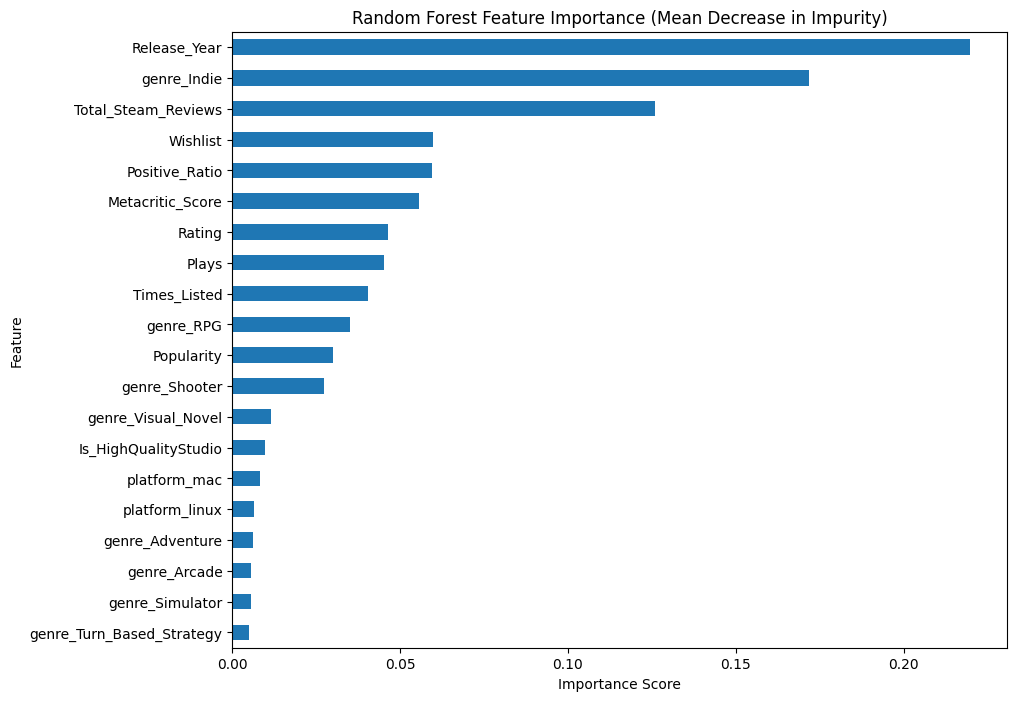

In [14]:
import matplotlib.pyplot as plt

# Cell 11: Final Model Training and Feature Importance

# 1. Train the final Random Forest model on the entire dataset
rf_model.fit(X.values, y.values)

# 2. Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a pandas Series for easy sorting and plotting
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# 3. Plot the top 20 features
plt.figure(figsize=(10, 8))
feature_importance_df.head(20).plot(kind='barh')
plt.title('Random Forest Feature Importance (Mean Decrease in Impurity)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error

# Make predictions on the full dataset using the final tuned model
y_pred_tuned = final_tuned_rf_model.predict(X.values)
print(y_pred_tuned)
# Calculate MAE and R2 score
mae_tuned = mean_absolute_error(y.values, y_pred_tuned)
r2_tuned = r2_score(y.values, y_pred_tuned)

print(f"Final Tuned Model - Mean Absolute Error (MAE): {mae_tuned:.4f}")
print(f"Final Tuned Model - R2 Score: {r2_tuned:.4f}")

[22.90005292 12.71648788 18.91133361  9.88887922 53.40169385 25.80746674
 48.86336051 20.94532697 28.0885029  53.2402      9.00843232 52.76776144
 28.23737962 24.48313297 16.12226937 28.05218912 44.38913043 21.25271786
 10.89840204 10.68094223 14.72570141 52.91555556 19.38891768 25.09493474
 22.9419228   3.2184619  22.64851627 24.93256265 54.77782609 39.52811932
 21.64199702 48.15676667 15.48951602 21.28882143 50.45571867 19.30284793
 16.15120897 21.93253144 31.70490635 50.69       15.3139606  50.18241418
 25.84159619 27.98576368 19.0659079  23.39703909 19.78937731 16.44068647
  6.66633333 17.42340308 24.60796269 19.42877377 22.58538262 34.91801944
 12.97316909 25.25139084 47.34847533 33.81012074 41.22865811 17.55416686
 23.33851568 52.18506803 33.78275791 35.72430612 21.33302906 16.36584607
 20.83098879 22.02447054 18.82247634 24.98251203 16.86211504 33.66109831
 39.54565293 16.0933316  59.15676667  7.4475     20.82078676 35.42783188
 18.5433539   9.77437578  8.7719     20.24958671 17

### Save the Trained Model

This cell saves the `final_tuned_rf_model` to a `.joblib` file, allowing you to load and reuse it later without retraining.

In [21]:
import joblib

# Define the filename for saving the model
model_filename = 'final_tuned_random_forest_model.joblib'

# Save the model to the specified file
joblib.dump(final_tuned_rf_model, model_filename)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to final_tuned_random_forest_model.joblib
